# Final LDA Model

In [95]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [96]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Test

In [97]:
# Data
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/DataSample_DSP_0712.csv', index_col=1) 
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]

# Data Final

In [98]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=1) 

In [99]:
df.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHARL_2021_1844.xml,0,ECLI:NL:GHARL:2021:1844,Strafrecht,Leeuwarden,Wahv 200.253.228,2021-02-25,[],[]
ECLI_NL_HR_2021_218.xml,1,ECLI:NL:HR:2021:218,Strafrecht,NaN,19/04191,2021-02-16,[],[]
ECLI_NL_PHR_2019_165.xml,2,ECLI:NL:PHR:2019:165,Strafrecht,NaN,16/06093,2019-01-08,[],[]
ECLI_NL_RBGEL_2018_50.xml,3,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,2018-01-08,[],[' tenlastelegging aan verdachte is ten last...
ECLI_NL_GHAMS_2019_194.xml,4,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,2019-01-25,[' het bewijs tegen de verdachte de kern...,[' tenlastelegging aan de verdachte is ten l...


In [100]:
df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

In [101]:
df_be.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHAMS_2019_194.xml,4,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,2019-01-25,[' het bewijs tegen de verdachte de kern...,[' tenlastelegging aan de verdachte is ten l...
ECLI_NL_GHSHE_2021_1801.xml,8,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,[' bewijsmiddelen indien tegen dit ve...,[]
ECLI_NL_GHARL_2020_820.xml,9,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[' bewijsmiddelen, feiten en omstandighed...",[' tenlastelegging aan verdachte is -na wijz...
ECLI_NL_RBROT_2021_2966.xml,16,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,2021-02-09,[' bewijswaardering 4.1.1. standpunt verd...,[]
ECLI_NL_RBMNE_2019_6577.xml,20,ECLI:NL:RBMNE:2019:6577,Strafrecht,Utrecht,16/018445-18,2019-01-18,[' bewijsmiddelen [slachtoffer]...,[' 2tenlastelegging de tenlastelegging is a...


In [102]:
df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)

In [103]:
df.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bete
filename,,,,,,,
ECLI_NL_RBGEL_2018_50.xml,3,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,2018-01-08,[][' tenlastelegging aan verdachte is ten la...
ECLI_NL_GHAMS_2019_194.xml,4,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,2019-01-25,[' het bewijs tegen de verdachte de kern...
ECLI_NL_RBOVE_2021_606.xml,7,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),2021-02-10,"[][' tenlastelegging de verdenking komt er, ..."
ECLI_NL_GHSHE_2021_1801.xml,8,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,[' bewijsmiddelen indien tegen dit ve...
ECLI_NL_GHARL_2020_820.xml,9,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[' bewijsmiddelen, feiten en omstandighed..."


# Tokenize 

In [104]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['bete']))

print(data_words[:1])

[['tenlastelegging', 'aan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'hij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf', 'jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', '

# Creating Bigram and Trigram Models

In [105]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['tenlastelegging', 'aan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'hij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf_jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', 'met'

# Remove Stopwords, Make Bigrams and Lemmatize

In [106]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [107]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tenlastelegging', 'verdenken', 'last', 'leggen', 'periode', 'oostenrijk', 'opzettelijk', 'minderjarig', 'weten', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'onttrekken', 'wettig', 'stellen', 'gezag', 'opzicht', 'desbevoegd', 'uitoefenen', 'minderjarig', 'twaalf_jar', 'oud', 'list', 'bezigen', 'bestaan', 'verdenken', 'school', 'minderjarig', 'strijd', 'waarheid', 'mededeel', 'minderjarig', 'afspraak', 'tandarts', 'minderjarig', 'daarvoor', 'vroeger', 'halen', 'school', 'verdenken', 'huis', 'lok', 'verdachte', 'echtgenote', 'genaamd', 'naam', 'maken', 'afspraak', 'woonboulevard', 'beweerdelijk', 'gaan', 'shopp', 'verdenken', 'paspoort', 'kleding', 'toiletartikel', 'minderjarig', 'woning', 'toverweging', 'aanzien', 'bewijs', 'feit', 'grond', 'bewijsmiddel', 'volgen', 'ver', 'discussie', 'staan', 'vaststellen', 'aangeefster', 'naam', 'verdenken', 'trouwen', 'samen', 'kind', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', '

#  Create the Dictionary and Corpus needed for Topic Modeling

In [108]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# corpus1 = [str(item) for item in corpus]

# View
print(corpus[:1])

[[(0, 6), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 5), (34, 4), (35, 4), (36, 1), (37, 2), (38, 3), (39, 1), (40, 4), (41, 1), (42, 1), (43, 1), (44, 2), (45, 10), (46, 2), (47, 1), (48, 3), (49, 3), (50, 3), (51, 3), (52, 2), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 6), (60, 1), (61, 10), (62, 4), (63, 1), (64, 1), (65, 3), (66, 2), (67, 2), (68, 2), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 4), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 3), (91, 1), (92, 3), (93, 1), (94, 4), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 1), (108, 1), (109, 3), (110, 

In [109]:
# Id word
id2word[0]

'aangeefster'

# Building the Topic Model

In [110]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [111]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"verdenken" + 0.031*"slachtoffer" + 0.021*"zien" + '
  '0.013*"medeverdacht" + 0.012*"verbalisant" + 0.012*"man" + '
  '0.010*"verklaren" + 0.010*"komen" + 0.009*"rechtbank" + 0.009*"verklaring"'),
 (1,
  '0.064*"slachtoffer" + 0.034*"verdenken" + 0.027*"althans" + 0.026*"naam" + '
  '0.023*"ander" + 0.015*"geval" + 0.012*"weten" + 0.010*"geweld" + '
  '0.009*"goed" + 0.009*"aangeefster"'),
 (2,
  '0.041*"verdenken" + 0.021*"medeverdacht" + 0.018*"naam" + 0.012*"uur" + '
  '0.011*"aantreffen" + 0.011*"adres" + 0.010*"rechtbank" + 0.010*"kenteken" + '
  '0.009*"telefoonnummer" + 0.008*"auto"'),
 (3,
  '0.055*"verdenken" + 0.020*"hof" + 0.011*"feit" + 0.011*"verklaren" + '
  '0.010*"bewijzen" + 0.009*"benadelen" + 0.008*"rechtbank" + 0.007*"oordeel" '
  '+ 0.007*"omstandigheid" + 0.007*"artikel"'),
 (4,
  '0.033*"verdenken" + 0.025*"naam" + 0.018*"bedrijf" + 0.016*"benadelen" + '
  '0.013*"althans" + 0.013*"geld" + 0.012*"telkens" + 0.012*"ander" + '
  '0.010*"periode" + 0.

# Compute Model Perplexity and Coherence Score

In [112]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.197103925749577

Coherence Score:  0.4805791301370833


# Visualize the topics-keywords

In [113]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.160867 -0.095457       1        1  25.358229
3     -0.117131  0.096950       2        1  22.948805
2     -0.038201  0.051120       3        1  19.644268
1      0.139161 -0.191866       4        1  19.475390
4      0.177037  0.139254       5        1  12.573308, topic_info=            Term          Freq         Total Category  logprob  loglift
975  slachtoffer  19289.000000  19289.000000  Default  10.0000  10.0000
61          naam  11156.000000  11156.000000  Default   9.0000   9.0000
581      althans   7107.000000   7107.000000  Default   8.0000   8.0000
310          hof   4836.000000   4836.000000  Default   7.0000   7.0000
750      bedrijf   2537.000000   2537.000000  Default   6.0000   6.0000
..           ...           ...           ...      ...      ...      ...
61          naam   2936.609008  11156.906926   Topic5  -3.7019   0.7388
110    verdenken   3974.953597  39434.222678   Topic5  -3.3991  -0.2210
581      althans   1601.621121   7107.221687   Topic5  -4.3081   0.5835
77       periode   1139.603440   3053.603011   Topic5  -4.6485   1.0880
163        ander   1368.663109   7379.579492   Topic5  -4.4653   0.3887

[150 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
0         1  0.060400       aangeefster
0         2  0.373535       aangeefster
0         4  0.565870       aangeefster
721       1  0.676185          aangever
721       4  0.256085          aangever
...     ...       ...               ...
569       2  0.080835              zien
569       3  0.083236              zien
569       4  0.000480              zien
569       5  0.012325              zien
3353      1  0.997803  zover_inhoudenen

[318 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

# How to find the optimal number fo topics for LDA?

In [114]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [115]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)  # 2,40,6

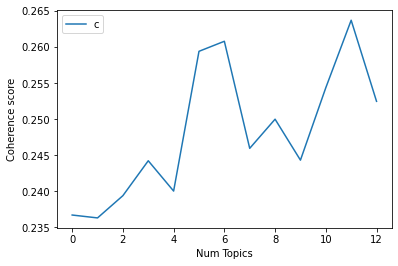

In [116]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# TF-IDF

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [118]:
sample = list(df['bete'])

# Approach 2

In [119]:
dat_lem_untok = [" ".join(x) for x in data_lemmatized]
tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)

In [120]:
tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [121]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [122]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,aa,0.0
1,0,aa_flesje,0.0
2,0,aaan,0.0
3,0,aaei,0.0
4,0,aafe,0.0
...,...,...,...
30914795,1447,zwoll,0.0
30914796,1447,zwolle,0.0
30914797,1447,zwz,0.0
30914798,1447,zygoma,0.0


In [123]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [124]:
top_tfidf[top_tfidf['term'].str.contains('hof')]

,document,term,tfidf
29008,1,hof,0.175662
71708,3,hof,0.527818
93058,4,hof,0.197094
114408,5,hof,0.155718
199808,9,hof,0.272591
...,...,...,...
29897658,1400,hof,0.231139
30196558,1414,hof,0.315010
30217908,1415,hof,0.186256
30708958,1438,hof,0.275683


In [125]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['benadelen', 'kasboek', 'hof']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:500,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 1200)

alt.LayerChart(...)